# Import Libraries

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import glob
import os
from google.colab import files

from PIL import Image
from timeit import default_timer as timer
from tqdm import tqdm

import torch
import torch.hub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torchvision
from torchvision import datasets
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchsummary import summary

from sklearn.metrics import confusion_matrix

!pip install timm
torch.manual_seed(42)

# Common Functions

In [46]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device):

    # Send model to GPU
    model.to(device)
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += accuracy_fn(true=y.cpu(),
                                     pred=y_pred.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss.item()/counter, refresh=True)

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

        # Calculate loss and accuracy per epoch and print out what's happening
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)

    return train_loss.item(), train_acc

In [47]:
def test_step(model,
              data_loader,
              loss_fn,
              accuracy_fn,
              device):

    # Send model to GPU
    model.to(device)

    # put model in eval mode
    model.eval()
    test_loss, test_acc, counter = 0, 0, 0
    with torch.no_grad():
        with tqdm(data_loader, desc ="   test") as test_tqdm:
            for X, y in test_tqdm:
                # Send data to GPU
                X, y = X.to(device), y.to(device)

                # 1. Forward pass
                test_pred = model(X)

                # 2. Calculate loss and accuracy
                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(true=y.cpu(),
                                        pred=test_pred.cpu())
                counter += 1
                test_tqdm.set_postfix(test_acc=test_acc/counter, test_loss=test_loss.item()/counter, refresh=True)

            # Adjust metrics and print out
            test_loss /= len(data_loader)
            test_acc  /= len(data_loader)

    return test_loss.item(), test_acc

In [48]:
def accuracy_fn(true, pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 5)

In [85]:
def optimizer(model):
  learning_rate = 0.0001
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  return optimizer

In [49]:
def fit(model, train_dataloader, test_dataloader, optimizer, epochs, lr_scheduler, loss_fn, device):
  train_epoch_loss = []
  train_epoch_accuracy = []
  test_epoch_loss = []
  test_epoch_accuracy = []

  train_time_start = timer()

  for epoch in range(epochs):
      print("EPOCH {}/{} :".format(epoch +1, epochs))
      train_loss, train_acc = train_step(data_loader=train_dataloader,
                                                model=model,
                                                loss_fn=loss_fn,
                                                optimizer=optimizer,
                                                accuracy_fn=accuracy_fn,
                                                device=device
                                                )
      test_loss, test_acc = test_step(data_loader=test_dataloader,
                                      model=model,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn,
                                      device=device
                                      )

      train_epoch_loss.append(train_loss)
      train_epoch_accuracy.append(train_acc)
      test_epoch_loss.append(test_loss)
      test_epoch_accuracy.append(test_acc)

      # Update learning rate based on test accuracy
      lr_scheduler.step(test_acc)

  train_time_end = timer()
  total_time = train_time_end - train_time_start
  print(f"\n\nTrain time: {total_time:.5f} seconds")
  return train_epoch_loss, test_epoch_loss, train_epoch_accuracy, test_epoch_accuracy

In [45]:
def accloss_plots(train_loss, test_loss, train_acc, test_acc):

    num_epochs = len(train_loss)
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(train_loss, 'r', label='Train')
    plt.plot(test_loss , 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=25, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.subplot(122)
    plt.plot(train_acc, 'r', label='Train')
    plt.plot(test_acc, 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=25, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.show();

In [65]:
def get_confusion_matrix(model, data_loader, device):
    # Send model to GPU
    model.to(device)

    # Put model in eval mode
    model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Get predicted labels
            predicted_labels.extend(torch.argmax(y_pred, dim=1).cpu().numpy())

            # Get true labels
            true_labels.extend(y.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    return cm

In [93]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Load and Preprocess ***First*** Dataset

In [50]:
# @title Download and unzip data
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
 90% 134M/149M [00:01<00:00, 123MB/s] 
100% 149M/149M [00:01<00:00, 123MB/s]


In [52]:
# This code is provided for colab
DIR_TRAIN = '/content/Training/'
DIR_TEST = '/content/Testing/'

In [53]:
# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a common size
    transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.Grayscale(num_output_channels=3),  # Convert images to RGB format
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the image pixel values
])

In [54]:
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ", len(classes))

train_paths = []
train_labels = []
test_paths  = []
test_labels = []

for label in classes:
    for image in os.listdir(DIR_TRAIN+label):
        train_paths.append(DIR_TRAIN+label+'/'+image)
        train_labels.append(label)
    for image in os.listdir(DIR_TEST+label):
        test_paths.append(DIR_TEST+label+'/'+image)
        test_labels.append(label)

print("\nTotal train images: ", len(train_paths))
print("Total test images: ", len(test_paths))

Total Classes:  4

Total train images:  5712
Total test images:  1311


In [55]:
class Brain_Tumor_MRI_Dataset(Dataset):
    def __init__(self, image_paths, labels, classes, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.class_to_label = {class_name: i for i, class_name in enumerate(classes)}
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.class_to_label[self.labels[index]]

        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.image_paths)

In [56]:
train_dataset = Brain_Tumor_MRI_Dataset(train_paths, train_labels, classes, transform)
test_dataset = Brain_Tumor_MRI_Dataset(test_paths, test_labels, classes, transform)

In [57]:
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    num_workers = 2,
    shuffle = True,
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    num_workers = 2,
    shuffle = False,
)

In [58]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Image size: torch.Size([3, 224, 224])
Label: 1


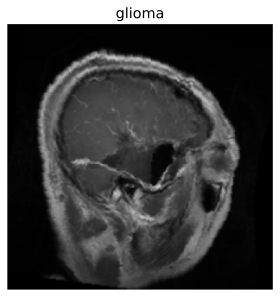

In [59]:
img, label = train_features_batch[0], train_labels_batch[0]
mean, std = 0.5, 0.5
img = std * img + mean
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.title(classes[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}")

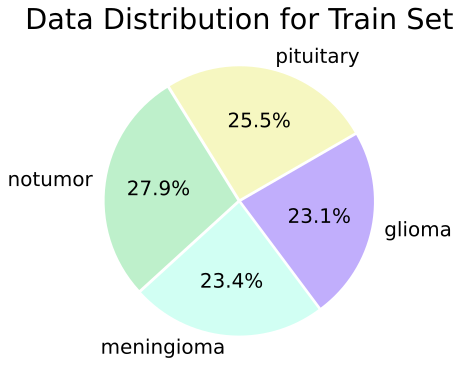

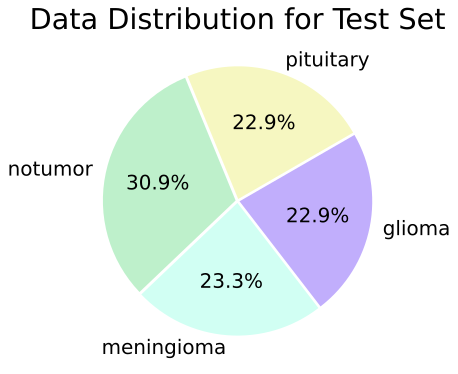

In [60]:
plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB', '#D1FFF3', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.title("Data Distribution for Train Set")
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015,0.015,0.015),
        startangle=30);

plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB', '#D1FFF3', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.title("Data Distribution for Test Set")
plt.pie([len([x for x in test_labels if x=='pituitary']),
         len([x for x in test_labels if x=='notumor']),
         len([x for x in test_labels if x=='meningioma']),
         len([x for x in test_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015,0.015,0.015),
        startangle=30);

# Fit **First** Dataset on Model

In [61]:
# Define number of classes from each dataset
num_classes = len(classes)

# Define the Transformer model
transformer_model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

transformer_model.head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(transformer_model.head.in_features, 256),
    nn.ELU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, num_classes)
)

# Unfreeze the 12th Transformer Block
for param in transformer_model.blocks[11].parameters():
    param.requires_grad = True

# Unfreeze the 11th Transformer Block
for param in transformer_model.blocks[10].parameters():
    param.requires_grad = True

transformer_model

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [63]:
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = optimizer(transformer_model)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=3,
                                 threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0.0000001, verbose=True)

In [ ]:
epochs_num = 10
train_loss1, test_loss1, train_acc1, test_acc1 = fit(
    transformer_model, train_dataloader, test_dataloader, optimizer, epochs_num, lr_scheduler, loss_fn, device)

EPOCH 1/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.70it/s, test_acc=95.7, test_loss=0.121]


EPOCH 2/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.72it/s, test_acc=97, test_loss=0.0976]


EPOCH 3/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.68it/s, test_acc=96.6, test_loss=0.0893]


EPOCH 4/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.73it/s, test_acc=98.2, test_loss=0.0517]


EPOCH 5/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.72it/s, test_acc=98.3, test_loss=0.0531]


EPOCH 6/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.64it/s, test_acc=98.7, test_loss=0.0479]


EPOCH 7/10 :


  train:  89%|████████▉ | 160/179 [02:47<00:19,  1.04s/it, train_acc=98.8, train_loss=0.0367]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.10/dist-pac

EPOCH 8/10 :


  train:  82%|████████▏ | 146/179 [02:32<00:34,  1.05s/it, train_acc=98.7, train_loss=0.0406]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/util

EPOCH 9/10 :


  train:  74%|███████▍  | 133/179 [02:19<00:48,  1.05s/it, train_acc=98.8, train_loss=0.0315]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/util

EPOCH 10/10 :


  train:  18%|█▊        | 32/179 [00:33<02:34,  1.05s/it, train_acc=99.3, train_loss=0.0157]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils



Train time: 2029.09418 seconds


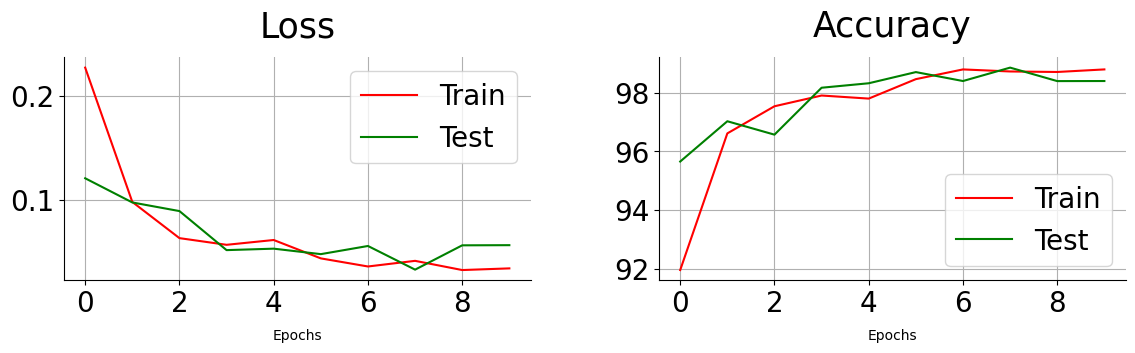

In [ ]:
accloss_plots(train_loss=train_loss1,
                  test_loss=test_loss1,
                  train_acc=train_acc1,
                  test_acc=test_acc1)

In [ ]:
# Calculate confusion matrix for train set
train_cm = get_confusion_matrix(transformer_model, train_dataloader, device)

# Calculate confusion matrix for test set
test_cm = get_confusion_matrix(transformer_model, test_dataloader, device)

# Plot the confusion matrix for train set
plot_confusion_matrix(train_cm, classes)

# Plot the confusion matrix for test set
plot_confusion_matrix(test_cm, classes)

# Load and Preprocess **Second** Dataset

In [70]:
# @title Download and unzip data
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d fernando2rad/brain-tumor-mri-images-44c

base_dir = '/content/base_dir'
!unzip -q brain-tumor-mri-images-44c.zip -d base_dir

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
brain-tumor-mri-images-44c.zip: Skipping, found more recently modified local copy (use --force to force download)
replace base_dir/Astrocitoma T1/005_big_gallery.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [71]:
IMAGE_SIZE=(224, 224)

def images_transforms(phase):
    if phase == 'training':
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.RandomRotation(degrees=(-25,20)),
             transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    return data_transformation

In [72]:
trainset = datasets.ImageFolder(base_dir,transform=images_transforms('training'))
len(trainset)

4479

In [73]:
num_classes = len(trainset.classes)
classes = trainset.classes
classes

['Astrocitoma T1',
 'Astrocitoma T1C+',
 'Astrocitoma T2',
 'Carcinoma T1',
 'Carcinoma T1C+',
 'Carcinoma T2',
 'Ependimoma T1',
 'Ependimoma T1C+',
 'Ependimoma T2',
 'Ganglioglioma T1',
 'Ganglioglioma T1C+',
 'Ganglioglioma T2',
 'Germinoma T1',
 'Germinoma T1C+',
 'Germinoma T2',
 'Glioblastoma T1',
 'Glioblastoma T1C+',
 'Glioblastoma T2',
 'Granuloma T1',
 'Granuloma T1C+',
 'Granuloma T2',
 'Meduloblastoma T1',
 'Meduloblastoma T1C+',
 'Meduloblastoma T2',
 'Meningioma T1',
 'Meningioma T1C+',
 'Meningioma T2',
 'Neurocitoma T1',
 'Neurocitoma T1C+',
 'Neurocitoma T2',
 'Oligodendroglioma T1',
 'Oligodendroglioma T1C+',
 'Oligodendroglioma T2',
 'Papiloma T1',
 'Papiloma T1C+',
 'Papiloma T2',
 'Schwannoma T1',
 'Schwannoma T1C+',
 'Schwannoma T2',
 'Tuberculoma T1',
 'Tuberculoma T1C+',
 'Tuberculoma T2',
 '_NORMAL T1',
 '_NORMAL T2']

In [74]:
split_ratio = 0.2
trainset, valset = torch.utils.data.random_split(trainset, [len(trainset)*(1-split_ratio), len(trainset)*split_ratio])
len(trainset), len(valset)

(3584, 895)

In [75]:
train_loader = DataLoader(trainset,batch_size=32,shuffle=True)
val_loader = DataLoader(valset,batch_size=32,shuffle=True)

In [76]:
def imshow(img):
    plt.figure(figsize=(20, 20))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

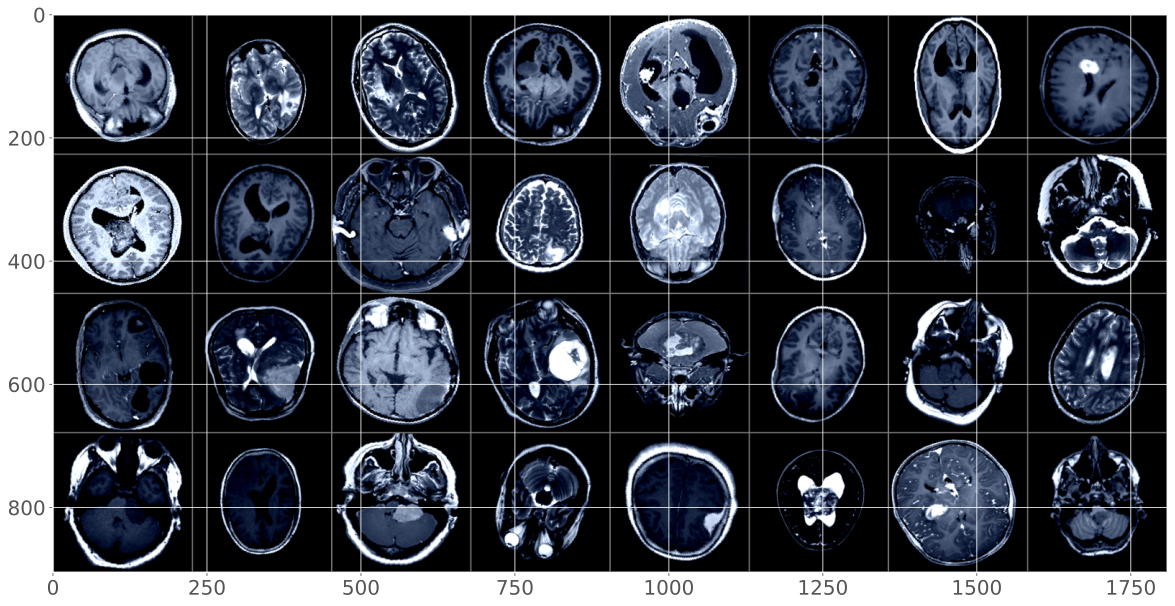

In [77]:
examples = iter(train_loader)
images,labels = next(examples)
imshow(torchvision.utils.make_grid(images))

# Fit **Second** Dataset on Model

In [82]:
# Define number of classes from each dataset
num_classes = len(classes)

# Define the Transformer model
transformer_model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

transformer_model.head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(transformer_model.head.in_features, 256),
    nn.ELU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, num_classes)
)

# Unfreeze the 12th Transformer Block
for param in transformer_model.blocks[11].parameters():
    param.requires_grad = True

# Unfreeze the 11th Transformer Block
for param in transformer_model.blocks[10].parameters():
    param.requires_grad = True

transformer_model

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [87]:
loss_fn2 = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer2 = optimizer(transformer_model)
lr_scheduler2 = ReduceLROnPlateau(optimizer2, mode='max', factor=0.6, patience=3,
                                 threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0.0000001, verbose=True)

In [88]:
epochs_num = 25
train_loss2, test_loss2, train_acc2, test_acc2 = fit(
    transformer_model, train_loader, val_loader, optimizer2, epochs_num, lr_scheduler2, loss_fn2, device)

EPOCH 1/25 :


   test: 100%|██████████| 28/28 [00:17<00:00,  1.61it/s, test_acc=56.3, test_loss=1.56]


EPOCH 2/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.73it/s, test_acc=72.7, test_loss=0.932]


EPOCH 3/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.74it/s, test_acc=82.6, test_loss=0.645]


EPOCH 4/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s, test_acc=86.2, test_loss=0.486]


EPOCH 5/25 :


   test: 100%|██████████| 28/28 [00:17<00:00,  1.63it/s, test_acc=85.3, test_loss=0.485]


EPOCH 6/25 :


   test: 100%|██████████| 28/28 [00:17<00:00,  1.61it/s, test_acc=90.1, test_loss=0.323]


EPOCH 7/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s, test_acc=92.3, test_loss=0.262]


EPOCH 8/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s, test_acc=91.3, test_loss=0.328]


EPOCH 9/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.74it/s, test_acc=87.9, test_loss=0.394]


EPOCH 10/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s, test_acc=88.5, test_loss=0.418]


EPOCH 11/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s, test_acc=91, test_loss=0.306]


Epoch 00011: reducing learning rate of group 0 to 6.0000e-05.
EPOCH 12/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.73it/s, test_acc=92.2, test_loss=0.249]


EPOCH 13/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.72it/s, test_acc=94.3, test_loss=0.195]


EPOCH 14/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s, test_acc=95, test_loss=0.194]


EPOCH 15/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s, test_acc=94.9, test_loss=0.197]


EPOCH 16/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s, test_acc=95.4, test_loss=0.163]


EPOCH 17/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s, test_acc=93.7, test_loss=0.229]


EPOCH 18/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.73it/s, test_acc=94.9, test_loss=0.193]


EPOCH 19/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s, test_acc=95.4, test_loss=0.189]


EPOCH 20/25 :


   test: 100%|██████████| 28/28 [00:17<00:00,  1.63it/s, test_acc=95, test_loss=0.195]


Epoch 00020: reducing learning rate of group 0 to 3.6000e-05.
EPOCH 21/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s, test_acc=95.4, test_loss=0.18]


EPOCH 22/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s, test_acc=95.6, test_loss=0.165]


EPOCH 23/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s, test_acc=95.5, test_loss=0.17]


EPOCH 24/25 :


   test: 100%|██████████| 28/28 [00:16<00:00,  1.73it/s, test_acc=95.5, test_loss=0.178]


EPOCH 25/25 :


   test: 100%|██████████| 28/28 [00:17<00:00,  1.62it/s, test_acc=95.3, test_loss=0.188]



Train time: 3400.57567 seconds


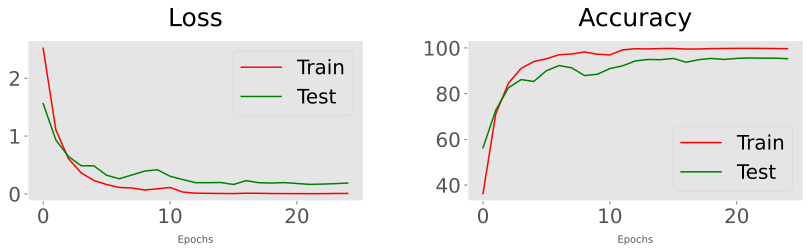

In [91]:
accloss_plots(train_loss=train_loss2,
                  test_loss=test_loss2,
                  train_acc=train_acc2,
                  test_acc=test_acc2)

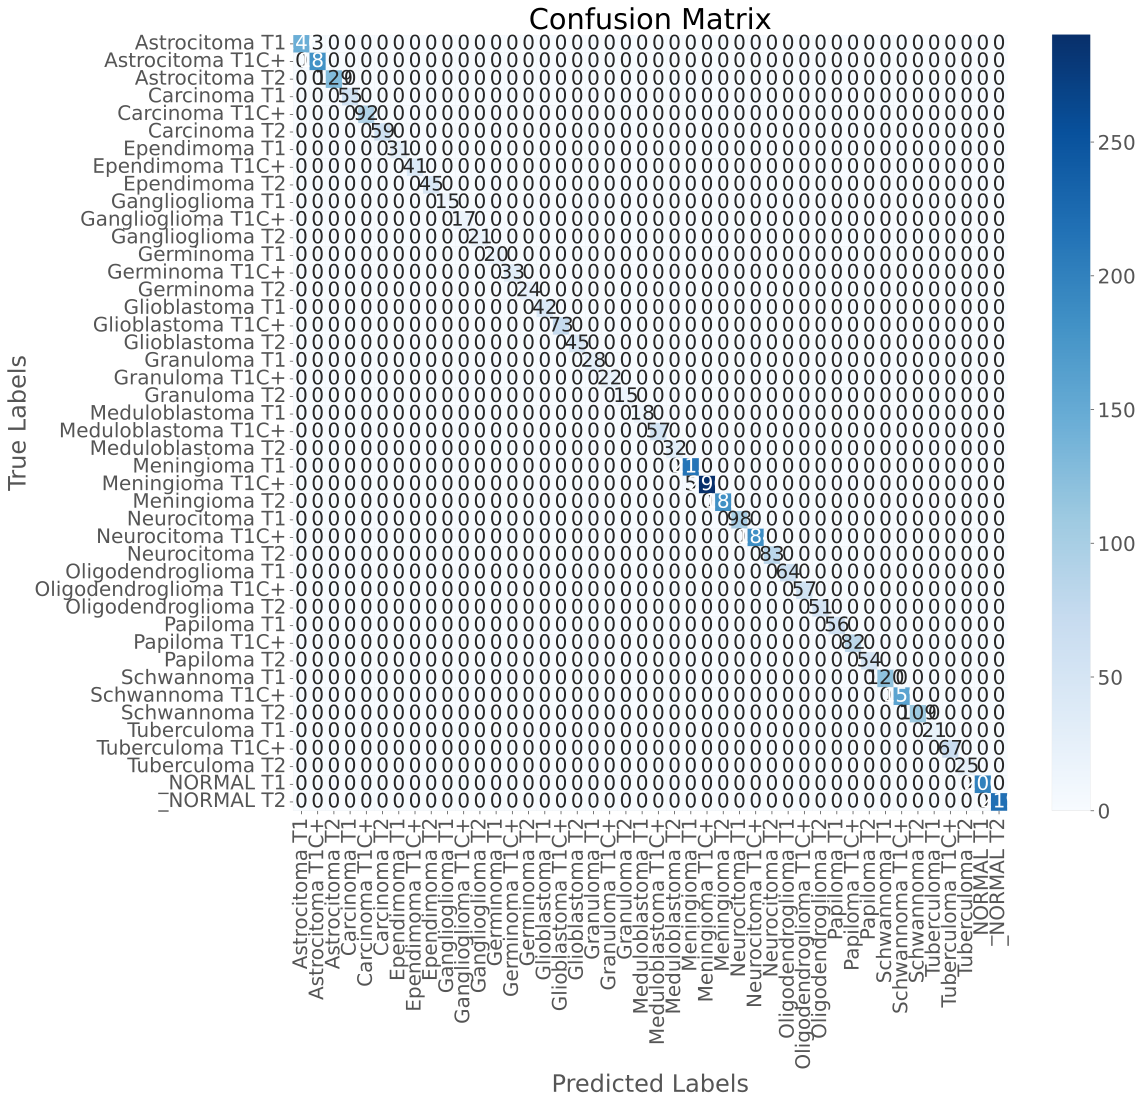

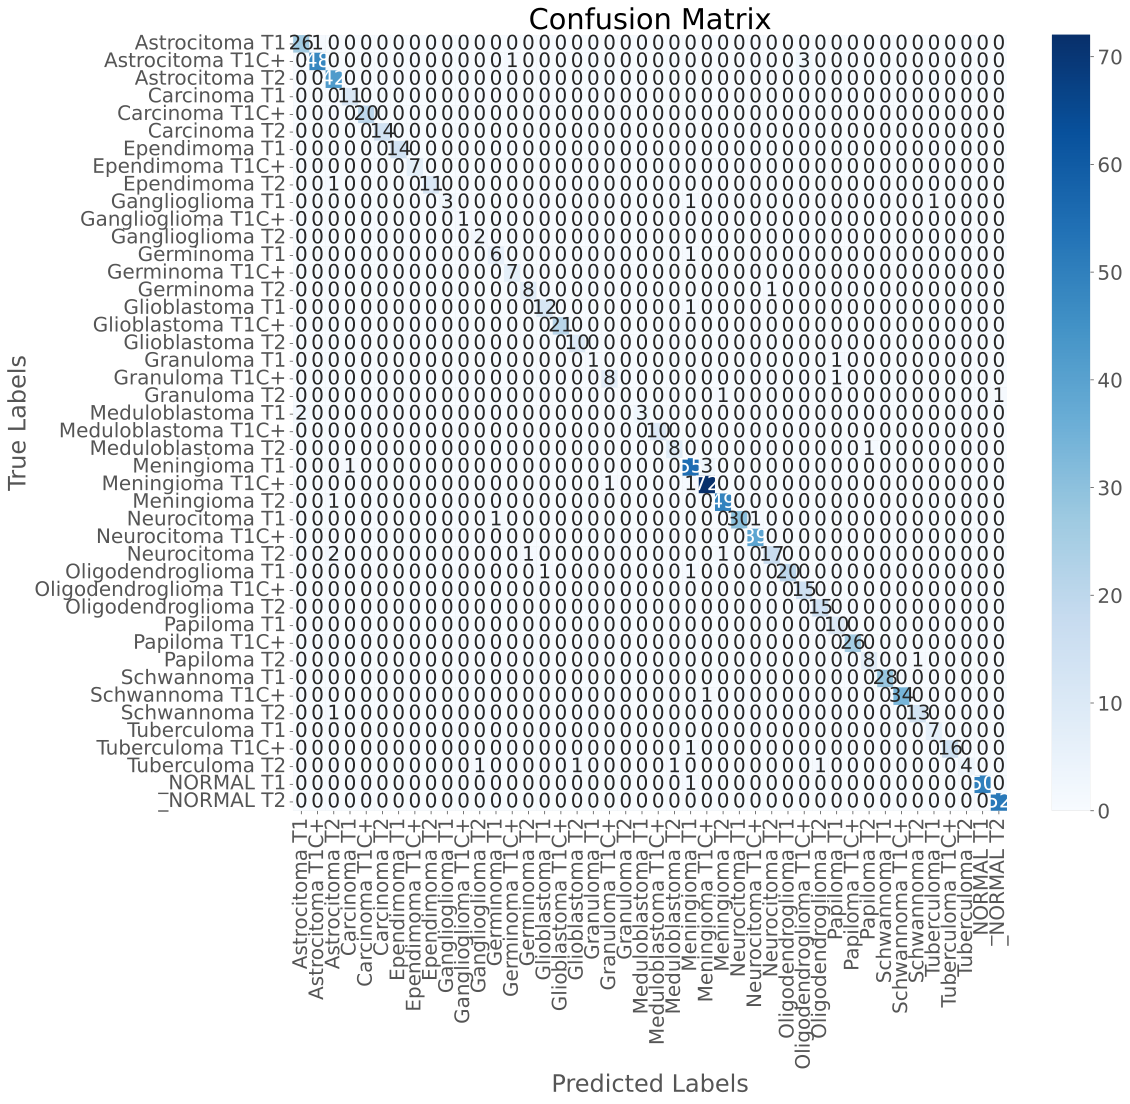

In [94]:
# Calculate confusion matrix for train set
train_cm = get_confusion_matrix(transformer_model, train_loader, device)

# Calculate confusion matrix for test set
test_cm = get_confusion_matrix(transformer_model, val_loader, device)

# Plot the confusion matrix for train set
plot_confusion_matrix(train_cm, classes)

# Plot the confusion matrix for test set
plot_confusion_matrix(test_cm, classes)